<a href="https://colab.research.google.com/github/cshuler/DL_watershed/blob/master/Scripts/testout1p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import scipy


from sklearn.preprocessing import StandardScaler
import keras 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


if not os.path.exists(os.path.join('.', 'workspace')):
    os.makedirs(os.path.join('.', 'workspace'))
workspace = os.path.join('.', 'workspace')

pd.set_option('display.max_rows', 30)  

In [7]:
# Clone DL repo.
!git clone -l -s git://github.com/cshuler/DL_watershed cloned-repo
%cd cloned-repo
# note that repo is cloned. Files saved will save to temprary space if in google colab
#i.e. try not to save any files you 

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4343, done.
remote: Counting objects: 100% (4343/4343), done.
remote: Compressing objects: 100% (382/382), done.
remote: Total 4343 (delta 3931), reused 4336 (delta 3928), pack-reused 0
Receiving objects: 100% (4343/4343), 35.65 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.
Checking out files: 100% (4405/4405), done.
/content/cloned-repo



# load up data files




In [0]:
# import precip data
preciprawdata = pd.read_csv(os.path.join('Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Precip_mm.csv' ), index_col=0,parse_dates=True)

#import flow data
LBJflowrawdata = pd.read_csv(os.path.join('Raw_Data_tutuila', 'Olkeba_data', 'LBJ_Alex_Q_CFSs.csv'), index_col=0, parse_dates=True)
LBJflowrawdata = LBJflowrawdata.resample('D').mean()     # subsample the 15 min data into daily values

In [0]:
mergeddata = pd.merge(preciprawdata, LBJflowrawdata, how='inner', left_index=True, right_index=True) 

# deal with the fact that the beginning and end of the datasets are missing, make them "gaps"
mergeddata['Q_CFS'][0] = mergeddata['Q_CFS'].mean()
mergeddata['Q_CFS'][-1] = mergeddata['Q_CFS'].mean()   # by setting the first and last value to the mean. Super dirty...

unbroken_data = mergeddata.dropna()       # remove any rows where there is no data (a gap)

In [0]:
# This is the function to mke a training dataset. 
""" Variables are: 
    unbroken_data:   is a pandas dataframe of weather variable data, with datetimmes as the index
    x_cols:          is a LIST of the column names for the input variables
    y_col:           is the name (string) of the column of the output variable
    TS_value:     is a decimal value defining how much of the dataset to use for training vs validation (0.99) = 99% training 1% validation
    
(Maybe use NAME: as a string name to assosiate with the output of this function?)
"""

def make_training_dataset(unbroken_data, x_cols, y_col, TS_value = 0.80):
    
    TRAIN_SPLIT = int(len(unbroken_data)*TS_value)     
    # split data for train and validation
    train_data = unbroken_data.iloc[:TRAIN_SPLIT]
    val_data = unbroken_data.iloc[TRAIN_SPLIT:]

    # set up the training datasets
    X_train = train_data[x_cols].values  
    # scale the x component of the training data
    X_train_scaler = StandardScaler().fit(X_train)
    X_train = X_train_scaler.transform(X_train)

    y_train = train_data[y_col].values                 # scale the y data too, and then make the scale unique to use it to unscale the final data later
    y_train = y_train.reshape(-1, 1)
    y_train_scaler = StandardScaler().fit(y_train)
    y_train = y_train_scaler.transform(y_train)


    # set up the validation datasets
    X_val = val_data[x_cols].values  
    # scale the x component of the training data
    X_val_scaler = StandardScaler().fit(X_val)
    X_val = X_val_scaler.transform(X_val)

    y_val = val_data[y_col].values
    y_val = y_val.reshape(-1, 1)
    y_val_scaler = StandardScaler().fit(y_val)
    y_val = y_val_scaler.transform(y_val)

    return X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler

In [0]:
# format trainng and validation data

x_cols = ['Precip_mm']           # define variable used for prediction
y_col  = 'Q_CFS'                    # define which variable to predict

X_train, y_train, X_val, y_val, train_data, val_data, y_train_scaler, y_val_scaler, X_train_scaler =  make_training_dataset(unbroken_data, x_cols, y_col, TS_value=0.8)

In [58]:
### This is used to Identify and label places where there are gaps in the data

def find_date_gaps(dataset_raw, Colinterest):

    a = dataset_raw[Colinterest].values  # Extract out relevant column from dataframe as array
    ## Now gap filling time: 
    # First: all of this is to go through each dataset and identify the start and the end of each gap. 

    m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits

    gapstarts_L = []; gapends_L = []
    # this is if the series started late, i.e. the first gap is at the beginning
    if ss[0][0] != 0:     
        gapstart = 0
        gapstarts_L.append(gapstart)
        for m in ss:
            gapstart2 = m[1]
            gapstarts_L.append(gapstart2)
            gapends_L.append(m[0])
        del gapstarts_L[-1]                       # the end number is not the start of a new gap so delete this 

    # this is if the series starst at the beginning of the data period, first gap is in the middle 
    for m in ss:
        gapstarts_L.append(m[1])
        gapends_L.append(m[0])
    del gapstarts_L[-1]
    del gapends_L[0]

    gapstarts_Dates = []; gapends_Dates = []
    for h in gapstarts_L:
        date5 = dataset_raw.index[h]
        gapstarts_Dates.append(date5)   # this is a list of the starting date of all gaps
    for h in gapends_L:
        date5 = dataset_raw.index[h]
        gapends_Dates.append(date5)     # this is a list of all the ending dates of the gaps
           
    # list the 
    for idx, val in enumerate(gapstarts_Dates):
        length = gapends_Dates[idx] -gapstarts_Dates[idx]
        print("gap {} is {} from {} to {}".format(idx, length, gapstarts_Dates[idx], gapends_Dates[idx] ))
    
    return gapstarts_Dates, gapends_Dates

# run the function and see where there are date gaps
find_date_gaps(mergeddata, 'Q_CFS')

gap 0 is 5 days 00:00:00 from 2012-01-02 00:00:00 to 2012-01-07 00:00:00
gap 1 is 6 days 00:00:00 from 2012-04-04 00:00:00 to 2012-04-10 00:00:00
gap 2 is 5 days 00:00:00 from 2012-07-10 00:00:00 to 2012-07-15 00:00:00
gap 3 is 123 days 00:00:00 from 2012-10-11 00:00:00 to 2013-02-11 00:00:00
gap 4 is 137 days 00:00:00 from 2013-09-26 00:00:00 to 2014-02-10 00:00:00
gap 5 is 7 days 00:00:00 from 2014-09-24 00:00:00 to 2014-10-01 00:00:00
gap 6 is 1 days 00:00:00 from 2014-10-09 00:00:00 to 2014-10-10 00:00:00
gap 7 is 230 days 00:00:00 from 2015-06-20 00:00:00 to 2016-02-05 00:00:00
gap 8 is 5 days 00:00:00 from 2016-06-24 00:00:00 to 2016-06-29 00:00:00
gap 9 is 79 days 00:00:00 from 2016-10-13 00:00:00 to 2016-12-31 00:00:00


([Timestamp('2012-01-02 00:00:00'),
  Timestamp('2012-04-04 00:00:00'),
  Timestamp('2012-07-10 00:00:00'),
  Timestamp('2012-10-11 00:00:00'),
  Timestamp('2013-09-26 00:00:00'),
  Timestamp('2014-09-24 00:00:00'),
  Timestamp('2014-10-09 00:00:00'),
  Timestamp('2015-06-20 00:00:00'),
  Timestamp('2016-06-24 00:00:00'),
  Timestamp('2016-10-13 00:00:00')],
 [Timestamp('2012-01-07 00:00:00'),
  Timestamp('2012-04-10 00:00:00'),
  Timestamp('2012-07-15 00:00:00'),
  Timestamp('2013-02-11 00:00:00'),
  Timestamp('2014-02-10 00:00:00'),
  Timestamp('2014-10-01 00:00:00'),
  Timestamp('2014-10-10 00:00:00'),
  Timestamp('2016-02-05 00:00:00'),
  Timestamp('2016-06-29 00:00:00'),
  Timestamp('2016-12-31 00:00:00')])

In [63]:
# this is the creation of the DLNN model as a function
def define_model_dense(hidden_layer_sizes, input_shape, activation='relu', optimizer='sgd'):
    
    model = "reset"; del model   # redefine, then delete model to make sure previous model weights are DESTROIED!
    model = Sequential()
    
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(input_shape, )))
    for hl_size in hidden_layer_sizes[1: ]:
        model.add(Dense(hl_size, activation=activation))
    
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    
    return model


# Define the model: 

# DL hyperparameters
hidden_layer_sizes =  [12, 80, 80]
activation     = 'relu'
optimizer      = 'sgd'
input_shape    = 1           # this is the number of different variables used for training datasets

model = "reset"; del model                                                           # redefine, then delete model to make sure previous model weights are DESTROIED!
model = define_model_dense(hidden_layer_sizes, input_shape, activation, optimizer)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 80)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 81        
Total params: 7,625
Trainable params: 7,625
Non-trainable params: 0
_________________________________________________________________



In [68]:
# run the model

# Note using callbacks from ( https://www.machinecurve.com/index.php/2019/05/30/avoid-wasting-resources-with-earlystopping-and-modelcheckpoint-in-keras/ )
checkpoint_path = os.path.join(workspace, 'testmodel_random_callback_save2.h5')

keras_callbacks   = [EarlyStopping(monitor='val_loss', patience=300, mode='min', min_delta=0.001),
                      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')]

history = model.fit(X_train, y_train, epochs=2000,verbose=0, validation_data =(X_val,  y_val), callbacks=keras_callbacks)

## load the best saved model based on validation loss
model = load_model(checkpoint_path)
scores = model.evaluate(X_train, y_train, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

981/981 [==============================] - 0s 92us/step
Score: loss of 0.36881561417827546; mean_squared_error of 36.88156141782755%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


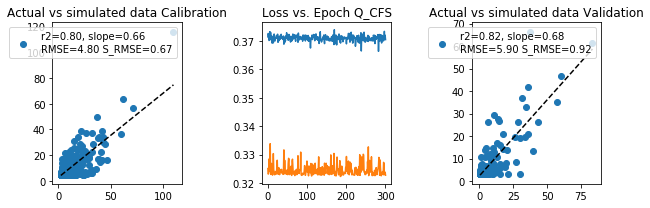

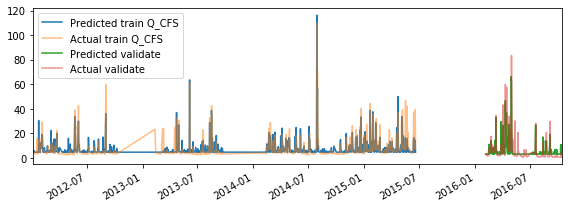

In [73]:
#### Plot results
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
####################################################     DELETE   fig.suptitle('Validation test plots', fontsize=16)

######## plot 1 to 1 for # view results of predictions on the calibration data 
y_pred_calibration = model.predict(X_train)
y_pred_calibration = y_train_scaler.inverse_transform(y_pred_calibration)    # unscale the final data baed on the scaler from the initial scaling cell abovee

xcal = np.squeeze(train_data[y_col].values)
ycal = np.squeeze(y_pred_calibration)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xcal, ycal)                              # get stats on regression
mea = np.mean(np.abs(xcal-ycal))
rmse = np.sqrt(np.mean(np.abs(xcal-ycal)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xcal)+np.mean(ycal))/2)                                 # standardize the RMSE as a % of the mean
ax[0].plot(np.unique(xcal), np.poly1d(np.polyfit(xcal, ycal, 1))(np.unique(xcal)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[0].scatter(xcal, ycal, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[0].set_title('Actual vs simulated data Calibration')
ax[0].legend()
plt.tight_layout()

###### Plot losses
ax[1].set_title('Loss vs. Epoch {}'.format(y_col))
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
plt.tight_layout()

###### plot 1 to 1 for # view results of predictions on the validation data 
y_pred_validation = model.predict(X_val)
y_pred_validation = y_val_scaler.inverse_transform(y_pred_validation)    # unscale the final data baed on the scaler from the initial scaling cell abovee
plt.tight_layout()

xval = np.squeeze(val_data[y_col].values)
yval = np.squeeze(y_pred_validation)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)                              # get stats on regression
mea = np.mean(np.abs(xval-yval))
rmse = np.sqrt(np.mean(np.abs(xval-yval)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
Std_RMSE = rmse/((np.mean(xval)+np.mean(yval))/2)                                 # standardize the RMSE as a % of the mean
ax[2].plot(np.unique(xval), np.poly1d(np.polyfit(xval, yval, 1))(np.unique(xval)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
ax[2].scatter(xval, yval, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
ax[2].set_title('Actual vs simulated data Validation')
ax[2].legend()
plt.tight_layout() 

##### time series plot
plt.figure(figsize=(8, 3))
plt.plot(train_data.index, ycal, label='Predicted train {}'.format(y_col))
train_data[y_col].plot(label='Actual train {}'.format(y_col) , alpha = .5)
plt.plot(val_data.index, yval, label='Predicted validate')
val_data[y_col].plot(label='Actual validate', alpha = .5)
plt.legend(loc='best')
plt.tight_layout()

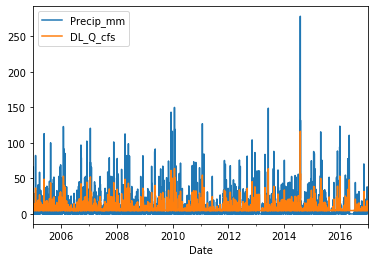

In [95]:
X_fill = preciprawdata['Precip_mm'].to_numpy()
X_fill =  X_train_scaler.transform([X_fill])                           # scale existing data in other columns 

# now model streamflow for the whole period where we have precip data
y_pred_fill = model.predict(np.squeeze(X_fill))
y_pred_fill = y_train_scaler.inverse_transform(y_pred_fill)    # unscale the final data baed on the scaler from the initial scaling cell above 

Magicdata = preciprawdata.copy()
Magicdata['DL_Q_cfs'] = y_pred_fill

Magicdata.plot()

In [97]:
Magicdata['DL_Q_cfs'].mean()

7.268522262573242

In [0]:
# now need to baseflow separate, and see how it predicts BF-RO partitioning and figure out some classic hydrograph stats, med flow mean flow, 90% low flow 100 year flood etc...
